In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




/kaggle/input/small-lcl-data/LCL-June2015v2_99.csv


In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#!pip install -U pip
#!pip install -U setuptools wheel

!pip install autogluon


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s e

Creat two load forecasts...
1) half-hourly load forecast for next 24 hours
2) peak half-hour in the next 24 hours

Value...
* For electric network operator, minimize the amount of spinning reserve

Data...
* residential smart meter usage data
* weather data
* weather forecast data

In [3]:
# load half-hourly electric usage data
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
d = pd.read_csv('/kaggle/input/small-lcl-data/LCL-June2015v2_99.csv', parse_dates=["DateTime"])

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   LCLid                    1000000 non-null  object        
 1   stdorToU                 1000000 non-null  object        
 2   DateTime                 1000000 non-null  datetime64[ns]
 3   KWH/hh (per half hour)   1000000 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 30.5+ MB


In [5]:
# convert usage to floats
# print(d.iloc[3])
d.iloc[:, 3] = pd.to_numeric(d.iloc[:, 3], errors='coerce')
# print(d.dtypes)

In [6]:
# set timestamp as the index
d.set_index('DateTime')
# sample.set_index('DateTime')

,LCLid,stdorToU,KWH/hh (per half hour)
DateTime,,,
2013-08-06 07:00:00,MAC004221,Std,0.046
2013-08-06 07:30:00,MAC004221,Std,0.040
2013-08-06 08:00:00,MAC004221,Std,0.016
2013-08-06 08:30:00,MAC004221,Std,0.018
2013-08-06 09:00:00,MAC004221,Std,0.016
...,...,...,...
2013-06-29 07:00:00,MAC004268,Std,0.151
2013-06-29 07:30:00,MAC004268,Std,0.278
2013-06-29 08:00:00,MAC004268,Std,0.128


In [7]:
from pandas_profiling import ProfileReport

profile = ProfileReport(d, tsmode=True, sortby="DateTime")
profile.to_file('profile_report.html')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# visualize and handle duplicates
# d = d.drop_duplicates()
print(d.groupby(d.columns.tolist(),as_index=False).size())
dupes = d[d.duplicated()]
print(dupes)
print(dupes.index)
d = d.drop(index=dupes.index)

d.info()

            LCLid stdorToU            DateTime  KWH/hh (per half hour)   size
0       MAC004221      Std 2013-08-06 07:00:00                    0.046     1
1       MAC004221      Std 2013-08-06 07:30:00                    0.040     1
2       MAC004221      Std 2013-08-06 08:00:00                    0.016     1
3       MAC004221      Std 2013-08-06 08:30:00                    0.018     1
4       MAC004221      Std 2013-08-06 09:00:00                    0.016     1
...           ...      ...                 ...                      ...   ...
999282  MAC004268      Std 2013-06-29 07:00:00                    0.151     1
999283  MAC004268      Std 2013-06-29 07:30:00                    0.278     1
999284  MAC004268      Std 2013-06-29 08:00:00                    0.128     1
999285  MAC004268      Std 2013-06-29 08:30:00                    0.049     1
999286  MAC004268      Std 2013-06-29 09:00:00                    0.129     1

[999287 rows x 5 columns]
            LCLid stdorToU   DateTime

In [9]:
d.set_index('DateTime')

,LCLid,stdorToU,KWH/hh (per half hour)
DateTime,,,
2013-08-06 07:00:00,MAC004221,Std,0.046
2013-08-06 07:30:00,MAC004221,Std,0.040
2013-08-06 08:00:00,MAC004221,Std,0.016
2013-08-06 08:30:00,MAC004221,Std,0.018
2013-08-06 09:00:00,MAC004221,Std,0.016
...,...,...,...
2013-06-29 07:00:00,MAC004268,Std,0.151
2013-06-29 07:30:00,MAC004268,Std,0.278
2013-06-29 08:00:00,MAC004268,Std,0.128


<Axes: xlabel='Time'>

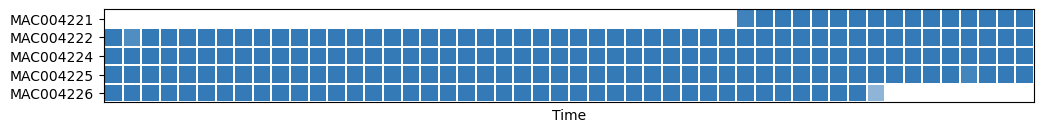

In [10]:
from pandas_profiling.visualisation.plot import timeseries_heatmap

timeseries_heatmap(dataframe=d, entity_column='LCLid', sortby='DateTime')

In [11]:
# visualize and handle outliers

# minumum and maximum timestamp for each house
print(d.groupby('LCLid').max()) 
print(d.groupby('LCLid').min())
print(d.groupby('LCLid').count())

print(d.groupby('LCLid').max().sort_values('DateTime'))
print(d.groupby('LCLid').min().sort_values('DateTime'))
print(d.groupby('LCLid').count().sort_values('DateTime'))

print(d.groupby('LCLid').agg(['min', 'max', 'count']))


          stdorToU            DateTime  KWH/hh (per half hour) 
LCLid                                                          
MAC004221      Std 2014-02-28 00:00:00                    1.005
MAC004222      Std 2014-02-28 00:00:00                    2.562
MAC004224      Std 2014-02-28 00:00:00                    4.329
MAC004225      Std 2014-02-28 00:00:00                    4.330
MAC004226      Std 2013-11-11 00:00:00                    3.095
MAC004227      Std 2013-01-29 00:00:00                    2.430
MAC004228      Std 2014-02-28 00:00:00                    3.271
MAC004230      Std 2014-02-28 00:00:00                    1.933
MAC004232      Std 2014-02-28 00:00:00                    1.854
MAC004233      Std 2014-02-28 00:00:00                    1.651
MAC004235      Std 2014-02-28 00:00:00                    1.255
MAC004237      Std 2014-02-28 00:00:00                    1.733
MAC004238      Std 2014-02-28 00:00:00                    1.638
MAC004240      Std 2013-06-05 23:30:00  

In [12]:
# which house has the highest peak load?

# which house has the highest total aggregate load?

# how variable / predictable is the timing of the peak load

# how accurate is the next 24 hours forecast profile overall?

# how accurate is the peak load forecast in next 24 hours?

# normalize and standardize


In [13]:
# extract one smartmeter for plotting
sample = d.query("LCLid == 'MAC004225'")
sample

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
71793,MAC004225,Std,2012-05-23 11:00:00,0.112
71794,MAC004225,Std,2012-05-23 11:30:00,0.113
71795,MAC004225,Std,2012-05-23 12:00:00,0.205
71796,MAC004225,Std,2012-05-23 12:30:00,0.131
71797,MAC004225,Std,2012-05-23 13:00:00,0.140
...,...,...,...,...
102747,MAC004225,Std,2014-02-27 22:00:00,1.341
102748,MAC004225,Std,2014-02-27 22:30:00,0.172
102749,MAC004225,Std,2014-02-27 23:00:00,0.161
102750,MAC004225,Std,2014-02-27 23:30:00,0.120


In [14]:
sample.iloc[:,3]
sample.iloc[:,2]

71793    2012-05-23 11:00:00
71794    2012-05-23 11:30:00
71795    2012-05-23 12:00:00
71796    2012-05-23 12:30:00
71797    2012-05-23 13:00:00
                 ...        
102747   2014-02-27 22:00:00
102748   2014-02-27 22:30:00
102749   2014-02-27 23:00:00
102750   2014-02-27 23:30:00
102751   2014-02-28 00:00:00
Name: DateTime, Length: 30939, dtype: datetime64[ns]

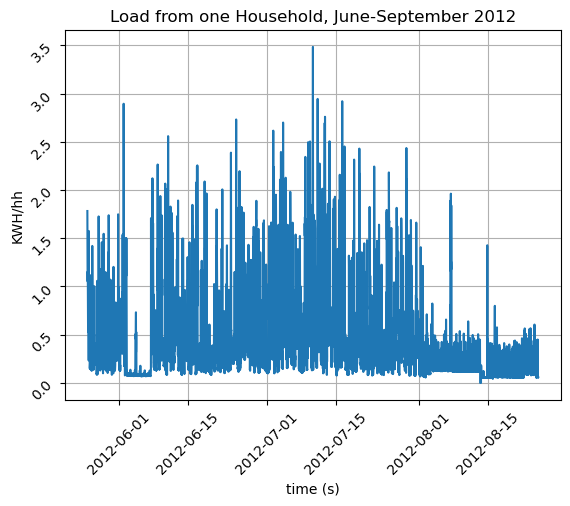

In [15]:
# Visualize load profile for one household meter
fig, ax = plt.subplots()
ax.plot(sample.iloc[100:4500,2], sample.iloc[100:4500,3])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Load from one Household, June-September 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [16]:
sample.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
71793,MAC004225,Std,2012-05-23 11:00:00,0.112
71794,MAC004225,Std,2012-05-23 11:30:00,0.113
71795,MAC004225,Std,2012-05-23 12:00:00,0.205
71796,MAC004225,Std,2012-05-23 12:30:00,0.131
71797,MAC004225,Std,2012-05-23 13:00:00,0.140


In [17]:
sample.DateTime.dtype
sample.set_index('DateTime')

,LCLid,stdorToU,KWH/hh (per half hour)
DateTime,,,
2012-05-23 11:00:00,MAC004225,Std,0.112
2012-05-23 11:30:00,MAC004225,Std,0.113
2012-05-23 12:00:00,MAC004225,Std,0.205
2012-05-23 12:30:00,MAC004225,Std,0.131
2012-05-23 13:00:00,MAC004225,Std,0.140
...,...,...,...
2014-02-27 22:00:00,MAC004225,Std,1.341
2014-02-27 22:30:00,MAC004225,Std,0.172
2014-02-27 23:00:00,MAC004225,Std,0.161


In [18]:
# calculate sum of all loads
aggLoad = pd.DataFrame(columns=['DateTime', 'AggregateLoad'])
limit = 100
counter = 1
reportFreq = 1000
nUniqueTstamps = d.DateTime.unique().size
for tstamp in d.DateTime.unique():
    # print('tstamp: ', tstamp)
    tstampSum = d.loc[d['DateTime'] == tstamp].iloc[:,3].sum()
    row = {
    "DateTime": tstamp,
    "AggregateLoad": tstampSum
    }
    # print(row)
    # aggLoad = aggLoad.append(row, ignore_index=True)
    # Create an index for the DataFrame
    # index = pd.Index([1])
    index = pd.Index([1])
    
    # Create the DataFrame
    row_df = pd.DataFrame(row, index=index)

    # Concatenate `row_df` to `aggLoad`
    aggLoad = pd.concat([aggLoad, row_df], ignore_index=True)
    
    counter += 1
    
    if counter % reportFreq == 0:
        print('Progress: ', (counter / nUniqueTstamps)*100)
    
aggLoad

Progress:  3.2263268269075653
Progress:  6.452653653815131
Progress:  9.678980480722696
Progress:  12.905307307630261
Progress:  16.13163413453783
Progress:  19.357960961445393
Progress:  22.58428778835296
Progress:  25.810614615260523
Progress:  29.03694144216809
Progress:  32.26326826907566
Progress:  35.489595095983226
Progress:  38.715921922890786
Progress:  41.94224874979835
Progress:  45.16857557670592
Progress:  48.394902403613486
Progress:  51.621229230521045
Progress:  54.84755605742861
Progress:  58.07388288433618
Progress:  61.300209711243745
Progress:  64.52653653815132
Progress:  67.75286336505889
Progress:  70.97919019196645
Progress:  74.20551701887402
Progress:  77.43184384578157
Progress:  80.65817067268914
Progress:  83.8844974995967
Progress:  87.11082432650427
Progress:  90.33715115341184
Progress:  93.5634779803194
Progress:  96.78980480722697


,DateTime,AggregateLoad
0,2013-08-06 07:00:00,4.172
1,2013-08-06 07:30:00,4.793
2,2013-08-06 08:00:00,6.773
3,2013-08-06 08:30:00,5.659
4,2013-08-06 09:00:00,5.272
...,...,...
30990,2012-12-18 15:20:01,0.000
30991,2012-12-18 15:20:02,0.000
30992,2013-02-06 18:22:38,0.000
30993,2012-12-18 15:20:03,0.000


In [19]:
aggLoad = aggLoad.sort_values(by=['DateTime'])
aggLoad = aggLoad.set_index('DateTime')
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30995 entries, 2012-05-23 10:30:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AggregateLoad  30995 non-null  float64
dtypes: float64(1)
memory usage: 484.3 KB


In [20]:
aggLoad['DateTime'] = aggLoad.index
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30995 entries, 2012-05-23 10:30:00 to 2014-02-28 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  30995 non-null  float64       
 1   DateTime       30995 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 726.4 KB


In [21]:
# inspect and fix records with zero load
# start with the aggregated records with zero load
AggZeros = aggLoad.query("AggregateLoad == 0")
AggZeros



,AggregateLoad,DateTime
DateTime,,
2012-12-18 15:19:59,0.0,2012-12-18 15:19:59
2012-12-18 15:20:00,0.0,2012-12-18 15:20:00
2012-12-18 15:20:01,0.0,2012-12-18 15:20:01
2012-12-18 15:20:02,0.0,2012-12-18 15:20:02
2012-12-18 15:20:03,0.0,2012-12-18 15:20:03
2012-12-18 15:20:04,0.0,2012-12-18 15:20:04
2013-02-06 18:22:38,0.0,2013-02-06 18:22:38


Observation: Some of the timestamps are not exactly on the half-hour
Question: How many of the timestamps are not exactly on the half-hour?

In [22]:
# inspect and fix records with zero load
# look at the raw records with zero load
# RawZeros = d.query("'KWH/hh (per half hour)' == 0")
# RawZeros

In [23]:
# inspect and fix records not exactly on the half-hour
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print(offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print(offRecs)

                     AggregateLoad            DateTime
DateTime                                              
2012-12-18 15:19:59            0.0 2012-12-18 15:19:59
2012-12-18 15:20:00            0.0 2012-12-18 15:20:00
2012-12-18 15:20:01            0.0 2012-12-18 15:20:01
2012-12-18 15:20:02            0.0 2012-12-18 15:20:02
2012-12-18 15:20:03            0.0 2012-12-18 15:20:03
2012-12-18 15:20:04            0.0 2012-12-18 15:20:04
2013-02-06 18:22:38            0.0 2013-02-06 18:22:38
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2012-12-18 15:19:59 to 2013-02-06 18:22:38
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  7 non-null      float64       
 1   DateTime       7 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.0 bytes
None
Empty DataFrame
Columns: [AggregateLoad, DateTime]
Index: []


In [24]:
# check for missing records in the aggregate load time series
# create reference time series
minTimestamp = aggLoad.index.min()
maxTimestamp = aggLoad.index.max()

print('minTimestamp: ', minTimestamp)
print('maxTimestamp: ', maxTimestamp)

date_range = pd.date_range(minTimestamp, maxTimestamp, freq='30Min')
reference_df = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
reference_df.index = date_range  # set index

print('reference index length: ', reference_df.shape)
print('aggLoad index length: ', aggLoad.shape)

print('reference_df: ', reference_df)
print('aggLoad: ', aggLoad)

print('reference index: ', reference_df.index)
print('aggLoad index: ', aggLoad.index)

# check for missing datetimeindex values based on reference index (with all values)
missing_dates = reference_df.index[~reference_df.index.isin(aggLoad.index)]

print('missing_dates: ', missing_dates)

minTimestamp:  2012-05-23 10:30:00
maxTimestamp:  2014-02-28 00:00:00
reference index length:  (30988, 1)
aggLoad index length:  (30988, 2)
reference_df:                        0
2012-05-23 10:30:00  13
2012-05-23 11:00:00   8
2012-05-23 11:30:00  19
2012-05-23 12:00:00   9
2012-05-23 12:30:00  14
...                  ..
2014-02-27 22:00:00   3
2014-02-27 22:30:00  12
2014-02-27 23:00:00   8
2014-02-27 23:30:00  17
2014-02-28 00:00:00   6

[30988 rows x 1 columns]
aggLoad:                       AggregateLoad            DateTime
DateTime                                              
2012-05-23 10:30:00          0.382 2012-05-23 10:30:00
2012-05-23 11:00:00          1.146 2012-05-23 11:00:00
2012-05-23 11:30:00          1.567 2012-05-23 11:30:00
2012-05-23 12:00:00          3.183 2012-05-23 12:00:00
2012-05-23 12:30:00          2.988 2012-05-23 12:30:00
...                            ...                 ...
2014-02-27 22:00:00          8.790 2014-02-27 22:00:00
2014-02-27 22:30:00       

                     AggregateLoad            DateTime
DateTime                                              
2012-05-23 10:30:00          0.382 2012-05-23 10:30:00
2012-05-23 11:00:00          1.146 2012-05-23 11:00:00
2012-05-23 11:30:00          1.567 2012-05-23 11:30:00
2012-05-23 12:00:00          3.183 2012-05-23 12:00:00
2012-05-23 12:30:00          2.988 2012-05-23 12:30:00
...                            ...                 ...
2014-02-27 22:00:00          8.790 2014-02-27 22:00:00
2014-02-27 22:30:00          7.083 2014-02-27 22:30:00
2014-02-27 23:00:00          6.616 2014-02-27 23:00:00
2014-02-27 23:30:00          5.552 2014-02-27 23:30:00
2014-02-28 00:00:00          4.845 2014-02-28 00:00:00

[30988 rows x 2 columns]


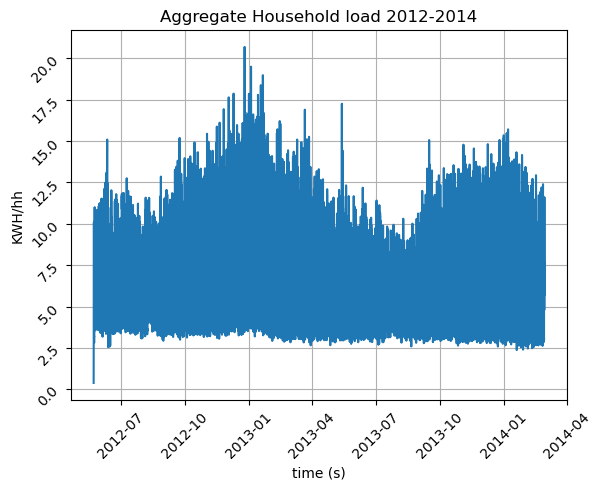

In [25]:
print(aggLoad)

fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad)

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [26]:
aggLoad.head()


,AggregateLoad,DateTime
DateTime,,
2012-05-23 10:30:00,0.382,2012-05-23 10:30:00
2012-05-23 11:00:00,1.146,2012-05-23 11:00:00
2012-05-23 11:30:00,1.567,2012-05-23 11:30:00
2012-05-23 12:00:00,3.183,2012-05-23 12:00:00
2012-05-23 12:30:00,2.988,2012-05-23 12:30:00


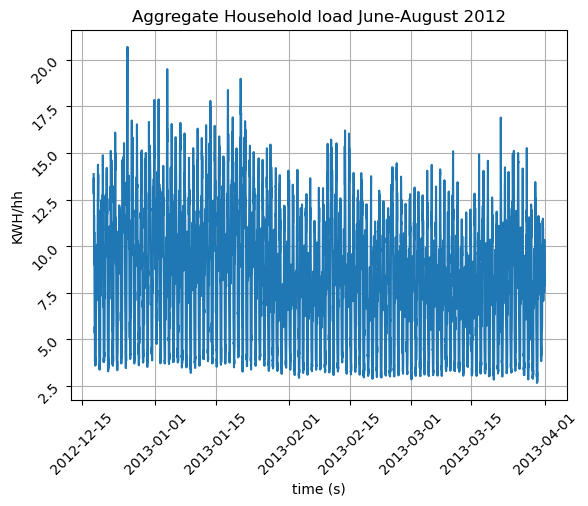

In [27]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[10000:15000], aggLoad.AggregateLoad[10000:15000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load June-August 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

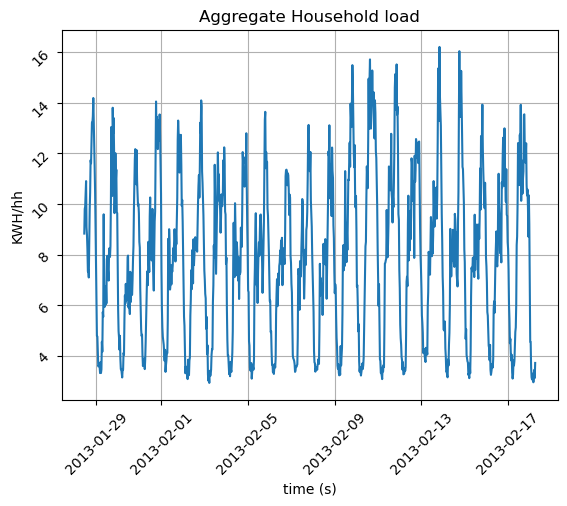

In [28]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12000:13000], aggLoad.AggregateLoad[12000:13000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

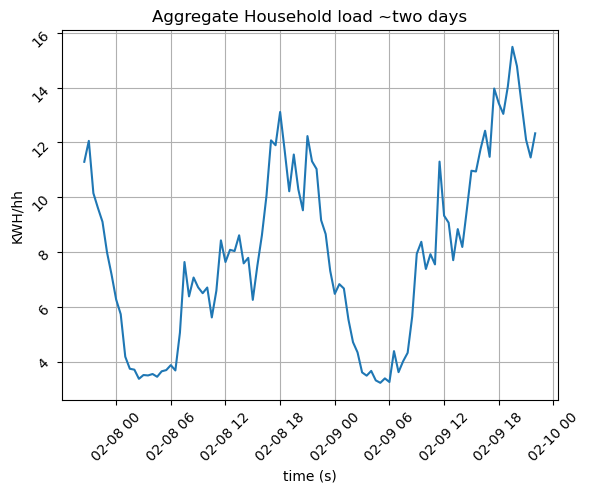

In [29]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12600], aggLoad.AggregateLoad[12500:12600])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load ~two days')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

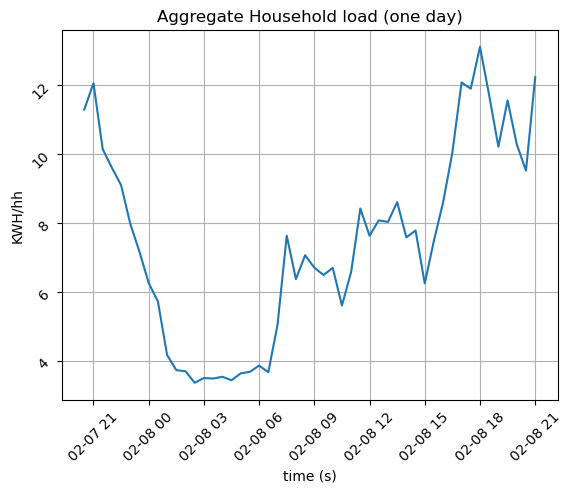

In [30]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12550], aggLoad.AggregateLoad[12500:12550])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load (one day)')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [31]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [32]:
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


In [33]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

In [34]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MASE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'num_val_windows': 1,
 'prediction_length': 48,
 'random_seed': None,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}
Provided training data set with 148060 rows, 200 items (item = single time series). Average time series length is 740.3. Data frequency is 'H'.
AutoGluon will save models to autogluon-m4-hourly/
AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'target'

Starting training. Start time is 2023-08-27 02:26:46
Models that will be 

In [35]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  621.022377  591.515051  601.644310  608.948218   
        1750-01-30 05:00:00  555.173747  513.444087  527.769022  538.098308   
        1750-01-30 06:00:00  512.971912  461.863725  479.408116  492.058856   
        1750-01-30 07:00:00  478.888969  419.874318  440.132836  454.740653   
        1750-01-30 08:00:00  456.222546  390.242160  412.891872  429.223907   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  615.189139  621.022377  626.855615  633.096535   
        1750-01-30 05:00:00  546.924302  555.173747  563.423191  572.249185   
        1750-01-30 06:00:00  502.868447  512.971912  523.075377  533.884968   
        1750-01-30 07:00:00  467.222493  478.888969  490.555446  503.037286   
        1750-01-30 08:00:00  443.179029  456.222546  469.266063  483.221185   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  640.400443  650.529702  
        1750-01-30 05:00:00  582.578471  596.903406  
        1750-01-30 06:00:00  546.535708  564.080099  
        1750-01-30 07:00:00  517.645103  537.903620  
        1750-01-30 08:00:00  499.553220  522.202931

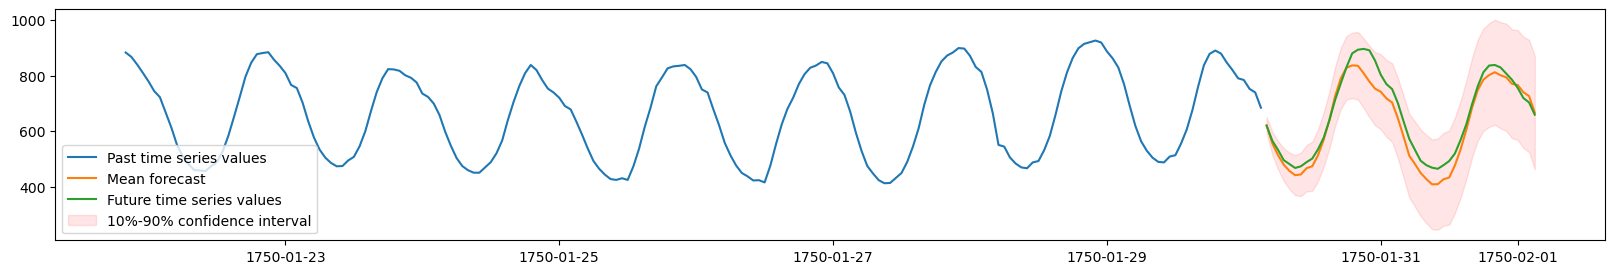

In [36]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

In [37]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,RecursiveTabular,-0.870271,-0.898770,2.256796,3.021607,38.312709,5
1,SeasonalNaive,-1.022854,-1.216909,0.403515,0.352997,0.147820,2
2,AutoETS,-1.778531,-1.939939,164.165547,140.003006,0.151364,4
3,Theta,-1.905365,-2.142531,21.724081,35.574922,0.146039,3
4,DeepAR,-1.959398,-1.757681,12.553273,13.181763,373.600767,6
5,Naive,-6.696079,-6.662942,10.182529,9.130777,0.155246,1


AutoGluon with our dataset

In [38]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [39]:
aggLoad.head()

,AggregateLoad,DateTime
DateTime,,
2012-05-23 10:30:00,0.382,2012-05-23 10:30:00
2012-05-23 11:00:00,1.146,2012-05-23 11:00:00
2012-05-23 11:30:00,1.567,2012-05-23 11:30:00
2012-05-23 12:00:00,3.183,2012-05-23 12:00:00
2012-05-23 12:30:00,2.988,2012-05-23 12:30:00


In [40]:
profile = ProfileReport(aggLoad, tsmode=True, sortby="DateTime")
profile.to_file('profile_report.html')
profile

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 profile = ProfileReport(aggLoad, tsmode=True, sortby="DateTime")                             │
│   2 profile.to_file('profile_report.html')                                                       │
│   3 profile                                                                                      │
│   4                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/typeguard/__init__.py:1033 in wrapper                    │
│                                                                                                  │
│   1030 │   def wrapper(*args, **kwargs):                                                         │
│   1031 │   │   memo = _CallMemo(python_func, _localns, args=args, kwargs=kwargs)                 │
│   1032 │   │   check_argument_types(memo)                                                        │
│ ❱ 1033 │   │   retval = func(*args, **kwargs)                                                    │
│   1034 │   │   try:                                                                              │
│   1035 │   │   │   check_return_type(retval, memo)                                               │
│   1036 │   │   except TypeError as exc:                                                          │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pandas_profiling/profile_report.py:138 in __init__       │
│                                                                                                  │
│   135 │   │   if tsmode and sortby:                                                              │
│   136 │   │   │   report_config.vars.timeseries.sortby = sortby                                  │
│   137 │   │                                                                                      │
│ ❱ 138 │   │   self.df = self.__initialize_dataframe(df, report_config)                           │
│   139 │   │   self.config = report_config                                                        │
│   140 │   │   self._df_hash = None                                                               │
│   141 │   │   self._sample = sample                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/typeguard/__init__.py:1033 in wrapper                    │
│                                                            

In [ ]:
# AutoGluon requires and ItemID Column, so adding one...
aggLoad['item_id'] = 'LoadSum'
aggLoad = aggLoad.astype({"item_id": str})

# Split the time series data into train, test, and validation datasets
train_size = int(len(aggLoad) * 0.8)  # 70% for training
test_size = int(len(aggLoad) * 0.1)   # 20% for testing
val_size = len(aggLoad) - train_size - test_size  # Remaining for validation

train_data = aggLoad[:train_size]
test_data = aggLoad[train_size:train_size+test_size]
val_data = aggLoad[train_size+test_size:]

print(train_data.head())
print(test_data.head())
print(val_data.head())
print(train_data.info())



In [ ]:
# print(pd.infer_freq(train_data.DateTime))
aggLoad.index.to_series().diff().value_counts()

In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    aggLoad,
    id_column="item_id",
    timestamp_column="DateTime"
)
train_data.head()

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="AggregateLoad",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)